In [10]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

from PIL import Image
import matplotlib.pyplot as plt 

from torchvision import transforms 
from torchvision import models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
img_source = '/home/hoseung/Pictures/oil.jpg'
img_obj = '/home/hoseung/Pictures/cartoon.jpg'

In [42]:
imsize = 512 if torch.cuda.is_available() else 128  # VGG expects 512 x 512 image

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [43]:
style_img = image_loader(img_source)
content_img = image_loader(img_obj)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [47]:
unloader = transforms.ToPILImage()

plt.ion()

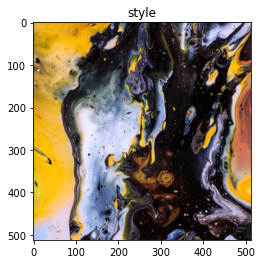

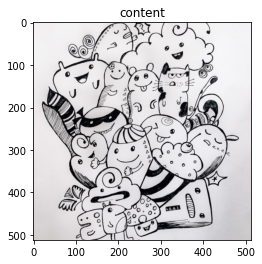

In [48]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
        
    plt.pause(0.01)
    
plt.figure()
imshow(style_img, title="style")

plt.figure()
imshow(content_img, title='content')

# Loss Functions

## Content Loss

In [66]:
class ContentLoss(nn.Module):
    """
    A Loss function returns the value on invoking "forward"
    """
    
    def __init__(self, target, ):
        super().__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### What does torch.nn.Module contains? 

->

## Style Loss

In [22]:
def gram_matrix(input):
    a,b,c,d = input.size()
    
    features = input.view(a*b, c*d)
    
    G = torch.mm(features, features.t())
    
    return G.div(a*b*c*d)

class StyleLoss(nn.Module):
    
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## import a NN for training (VGG)

In [23]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/hoseung/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [62]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

In [25]:
# These values are from the iamges VGG19 was trained on.
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [67]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, norm_mean, norm_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    
    cnn = copy.deepcopy(cnn) # Why deep copy?
    
    normalization = Normalization(norm_mean, norm_std).to(device)
    model = nn.Sequential(normalization)
    
    content_losses=[]
    style_losses=[]
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'reul_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized lyaer{}'.format(layer.__class__.__name__))
        
        model.add_module(name, layer)
        
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            
    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model = model[:i+1]
    
    return model, style_losses, content_losses

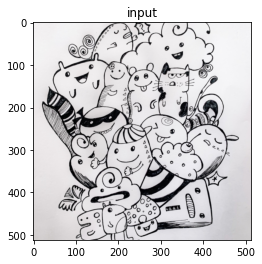

In [30]:
input_img = content_img.clone() # Difference b/w copy and clone?

plt.figure()
imshow(input_img, title='input')

In [31]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

## Closure construct

In [71]:
def run_style_transfer(cnn, norm_mean, norm_std, content_img, style_img, input_img, 
                       num_steps=300,
                       style_weight=1000000,
                       content_weight=1):
    model, style_losses, content_losses =  get_style_model_and_losses(cnn, 
                norm_mean, norm_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    
    print("Optimizing..")
    run = [0] 
    """
    integer run=0 is not initiated before initiating closure. Can't be accessed as a global variable.
    But the list run[0]=0 is available for the access. What makes the difference???? 
    """ 
    while run[0] <= num_steps:
        
        def closure():
            input_img.data.clamp_(0,1) # What is this for?
            
            optimizer.zero_grad()
            model(input_img)
            style_score=0
            content_score=0
            
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
                
            style_score *= style_weight
            content_score *= content_weight
            
            loss = style_score + content_score
            loss.backward() # ???
            
            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run}:")
                print(f"Style Loss : {style_score.item():.4f} Content Loss : {content_score.item():.4f}")
                print()
                
            return style_score + content_score
        
        optimizer.step(closure)
        
    input_img.data.clamp_(0,1)
    
    return input_img
            

<ipython-input-62-3389a1fbba87>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-62-3389a1fbba87>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 403.5023 Content Loss : 43.3024

run [100]:
Style Loss : 208.9474 Content Loss : 45.9530

run [150]:
Style Loss : 128.1257 Content Loss : 47.5074

run [200]:
Style Loss : 62.5043 Content Loss : 45.0373

run [250]:
Style Loss : 44.0582 Content Loss : 40.1907

run [300]:
Style Loss : 30.1447 Content Loss : 37.4477



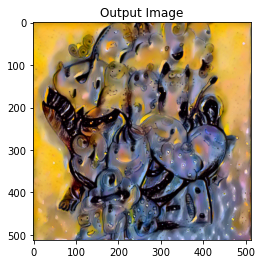

In [72]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()